In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-06 10:32:13.215509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746527533.670149      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746527533.808993      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
traindf=pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/train.csv')
testdf=pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/test.csv')

In [6]:
trainaud= '/kaggle/input/shl-hiring-assessment/Dataset/audios/train'
testaud= '/kaggle/input/shl-hiring-assessment/Dataset/audios/test'

In [7]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [8]:
if torch.cuda.is_available():
    model = model.cuda()

In [9]:
def extract_embedding(file_path):
    speecharr, sampling_rate = torchaudio.load(file_path)
    speech = speecharr[0].numpy()
    inputs = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}
        outputs = model(**inputs)
    return outputs.last_hidden_state[0].mean(dim=0).cpu().numpy()
train_embeddings=[]

In [10]:
for file in tqdm(traindf['filename']):
    path=os.path.join(trainaud,file)
    train_embeddings.append(extract_embedding(path))

100%|██████████| 444/444 [05:24<00:00,  1.37it/s]


In [12]:
X_train = np.stack(train_embeddings)
y_train = traindf['label'].values

In [13]:
regressor = Ridge(alpha=1.0)
regressor.fit(X_train, y_train)
train_preds = regressor.predict(X_train)

In [14]:
rmse = mean_squared_error(y_train, train_preds, squared=False)
pearson = pearsonr(y_train, train_preds)[0]
print(f"Train RMSE: {rmse:.4f}")
print(f"Train Pearson Correlation: {pearson:.4f}")

Train RMSE: 0.6775
Train Pearson Correlation: 0.7743


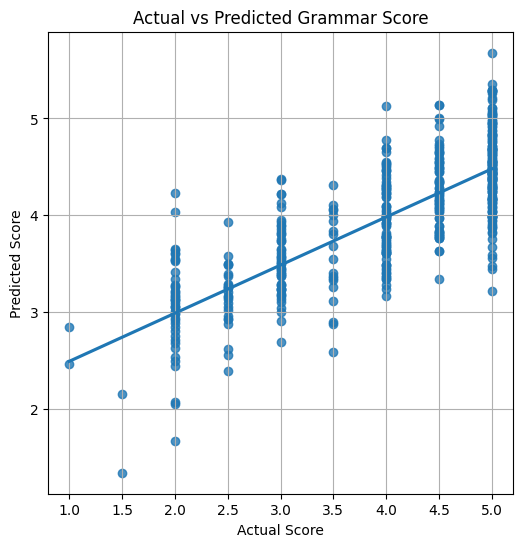

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


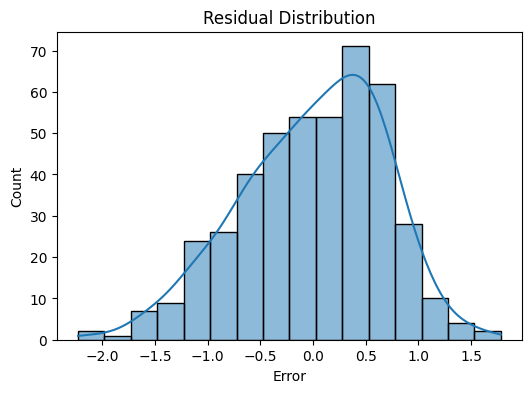

In [15]:
plt.figure(figsize=(6,6))
sns.regplot(x=y_train, y=train_preds, ci=None)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Grammar Score")
plt.grid(True)
plt.show()

residuals = y_train - train_preds
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.show()

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores, pearson_scores = [],[]

In [17]:
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    reg = Ridge(alpha=1.0)
    reg.fit(X_tr, y_tr)
    preds = reg.predict(X_val)
    
    rmse_scores.append(mean_squared_error(y_val, preds, squared=False))
    pearson_scores.append(pearsonr(y_val, preds)[0])

print(f"\n5-Fold CV RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"5-Fold CV Pearson: {np.mean(pearson_scores):.4f} ± {np.std(pearson_scores):.4f}")


5-Fold CV RMSE: 0.7905 ± 0.0383
5-Fold CV Pearson: 0.6605 ± 0.0370


In [20]:
X_test = np.stack(test_embeddings)
test_preds = regressor.predict(X_test)

In [21]:
test_embeddings = []
used_filenames = []
for file in tqdm(testdf['filename']):
    path = os.path.join(testaud, file)
    if not os.path.exists(path):
        print(f"Missing: {file}")
        continue
    emb = extract_embedding(path)
    test_embeddings.append(emb)
    used_filenames.append(file)

100%|██████████| 204/204 [02:08<00:00,  1.59it/s]


In [22]:
submission = pd.DataFrame({
    'filename': used_filenames,
    'label': test_preds
})
submission.to_csv('submission.csv', index=False)
print("submission.csv saved")

submission.csv saved
